In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import rc
from advi_jax.variational_distributions import MeanField
from advi_jax import ADVI
from advi_jax.metrics import kl_divergence
from advi_jax.init import initialize
import tensorflow_probability.substrates.jax as tfp
import distrax
import optax
import jaxopt
from time import time

rc('animation', html='jshtml')
dist = tfp.distributions

In [2]:
import logging
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger = logging.getLogger("root")
logger.addFilter(CheckTypesFilter())

## Coin Toss

### Useful functions

In [3]:
def plot_prior_lik_post(data, prior_dist, posterior_dist=None):
    plt.figure()
    theta_range = jnp.linspace(0.0, 1.0, 1000)
    a, b = prior_dist.concentration1, prior_dist.concentration0
    n_heads = jnp.sum(data)
    n_tails = len(data) - n_heads
    
    prior_probs = prior_dist.prob(theta_range)
    likelihood_probs = jnp.exp(jax.vmap(likelihood_log_prob_fun, in_axes=(0, None))(theta_range, data))
    if posterior_dist:
        posterior_probs = posterior_dist.prob(theta_range)
    true_posterior_probs = dist.Beta(a+n_heads, b+n_tails).prob(theta_range)

    plt.plot(theta_range, prior_probs, color="g", label="prior")
    if posterior_dist:
        print(posterior_probs.shape)
        plt.plot(theta_range, posterior_probs, label="variational posterior", color='b')
    plt.plot(theta_range, true_posterior_probs, label="true posterior", color='k')
    plt.legend(loc="upper left")
    
    plt.twinx()
    plt.plot(theta_range, likelihood_probs, label="likelihood", color="r")
    plt.legend(loc="upper right");
    print(f"n_heads={n_heads}, n_tails={n_tails}, a={a}, b={b}")
    
def likelihood_log_prob_fun(sample, data, **params):
    return jnp.sum(dist.Bernoulli(probs=sample).log_prob(data))

def inference_loop(key, params, model, optimizer, n_iterations, n_samples):
    def one_step(carry, key):
        params, state, data = carry
        value, grads = model.value_and_grad_fun(key, params, data, n_samples)
        updates, state = optimizer.update(grads, state)
        params = optax.apply_updates(params, updates)
        return (params, state, data), value

    keys = jax.random.split(key, n_iterations)
    state = optimizer.init(params)
    carry = (params, state, model.data)
    one_step = jax.jit(one_step, static_argnums=2)
    (params, state, data), values = jax.lax.scan(one_step, carry, keys)

    return values, params

### Simulate data

n_heads=20, n_tails=1, a=2.0, b=10.0


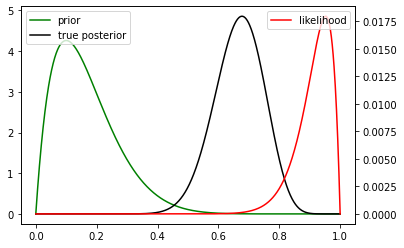

In [4]:
prior_dist = dist.Beta(2.0, 10.0)
data = jnp.array([1]* 20 + [0] * 1)

plot_prior_lik_post(data, prior_dist)

### Model definition

In [5]:
model = ADVI(prior_dist, likelihood_log_prob_fun, data)

variational_dist = MeanField(bijector=distrax.Sigmoid())

### Training with optax

initial params MeanField(mean=-1.0433589220046997, scale=2.049161195755005)
final params MeanField(mean=0.7266470789909363, scale=0.35533881187438965)
1.30 seconds


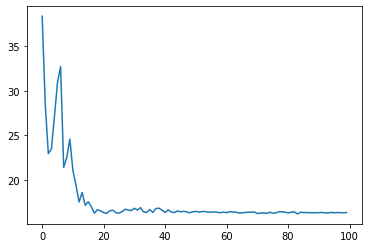

In [6]:
seed = 2
key = jax.random.PRNGKey(seed)
subkey = jax.random.PRNGKey(seed+1)

n_samples = 10
n_iterations=100
learning_rate = 0.1

t_init = time()

params = {"variational_dist": variational_dist}
params = initialize(key, params)  # randomly initialize the parameters
print("initial params", params["variational_dist"])
optimizer = optax.adam(learning_rate=0.1)
losses, params = inference_loop(subkey, params, model, optimizer, n_iterations, n_samples)
print("final params", params["variational_dist"])
print(f"{time()-t_init:.2f} seconds")
plt.plot(losses);

(1000,)
n_heads=20, n_tails=1, a=2.0, b=10.0


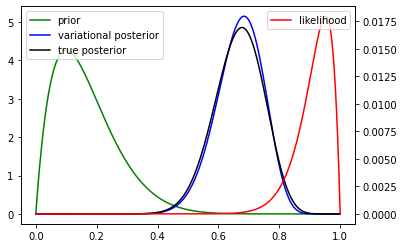

In [7]:
plot_prior_lik_post(data, prior_dist, posterior_dist=params["variational_dist"])

### Training with jaxopt

In [8]:
seed = 3
key = jax.random.PRNGKey(seed)
subkey = jax.random.PRNGKey(seed+1)

n_samples = 10
n_iterations=100
learning_rate = 0.1

t_init = time()

params = {"variational_dist": variational_dist}
params = initialize(key, params)  # randomly initialize the parameters
print("initial params", params["variational_dist"])

jaxopt_fun = jax.jit(lambda params, key, data, n_samples: model.objective_fun(key, params, data, n_samples), static_argnums=3)

optimizer = jaxopt.ScipyMinimize(method = "L-BFGS-B", fun=jaxopt_fun, jit=False)
res = optimizer.run(params, key, data, n_samples=100)
print("final params", res.params["variational_dist"])
print(f"{time()-t_init:.2f} seconds")

initial params MeanField(mean=-0.11756940186023712, scale=1.0418285131454468)
final params MeanField(mean=0.7195280194282532, scale=0.38842716813087463)
1.19 seconds


(1000,)
n_heads=20, n_tails=1, a=2.0, b=10.0


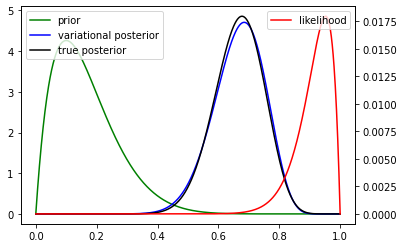

In [9]:
plot_prior_lik_post(data, prior_dist, posterior_dist=res.params["variational_dist"])

### Interactive demo

In [10]:
from ipywidgets import interact

In [11]:
@interact(n_heads=(1, 20), n_tails=(1, 20), a=(0.1, 100.0), b=(0.1, 100.0), seed=(0, 10), n_iterations=(1,1000), n_samples=(1,1000))
def plot_vi(n_heads=jnp.sum(data), n_tails=len(data) - jnp.sum(data), a=prior_dist.concentration1, b=prior_dist.concentration0, seed=seed, n_iterations=n_iterations, n_samples=n_samples):
    key = jax.random.PRNGKey(seed)
    subkey = jax.random.PRNGKey(seed+1)
    
    data = jnp.array([1]*n_heads + [0]*n_tails)
    prior_dist = dist.Beta(a, b)
    
    model = ADVI(prior_dist, likelihood_log_prob_fun, data)
    variational_dist = MeanField(bijector=distrax.Sigmoid())
    
    params = {"variational_dist": variational_dist}
    params = initialize(key, params)
#     print("initial params", params["variational_dist"])
    optimizer = optax.adam(learning_rate=0.1)
    losses, params = inference_loop(subkey, params, model, optimizer, n_iterations, n_samples)
#     print("final params", params["variational_dist"])
    
#     plt.plot(losses)
    plot_prior_lik_post(data, prior_dist, posterior_dist=params["variational_dist"])

interactive(children=(IntSlider(value=20, description='n_heads', max=20, min=1), IntSlider(value=1, descriptio…

### Appendix

In [30]:
import jax

funs = {'aab': lambda x:x**2, 'ab': lambda x:x**3}

jax.tree_map(lambda x, y: x(y), funs, {'aab': 2, 'ab': 3})

{'aab': 4, 'ab': 27}